In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import colors as colors

cmap_data = [(0, 'navy'),(0.1, 'blue'),(0.2,'DeepSkyBlue'),
             (0.3,'aquamarine'),(0.4,'PaleGreen'),(0.45,'moccasin'),
             (0.55,'moccasin'),(.6,'yellow'),(.7,'DarkOrange'),
             (.8,'red'),(1.0,'DarkRed')]
cmap = colors.LinearSegmentedColormap.from_list('correlationcolorscale', cmap_data)
plt.register_cmap('correlationcolorscale', cmap)

In [3]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
 
cmap_data = [(0, rgb2hex(130, 90, 80)), \
             (0.0625, rgb2hex(150, 110, 100)), \
             (0.125, rgb2hex(170, 130, 120)), \
             (0.1875, rgb2hex(180, 140, 130)), \
             (0.25, rgb2hex(190, 150, 140)), \
             (0.3125, rgb2hex(200, 160, 150)), \
             (0.375, rgb2hex(220, 185, 175)), \
             (0.475, rgb2hex(240, 215, 210)), \
             (0.495, rgb2hex(255, 255, 255)), \
             (0.505, rgb2hex(255, 255, 255)), \
             (0.525, rgb2hex(210, 255, 215)), \
             (0.5625, rgb2hex(150, 230, 155)), \
             (0.625, rgb2hex(110, 210, 115)), \
             (0.6875, rgb2hex(45, 180, 50)), \
             (0.75, rgb2hex(20, 170, 25)), \
             (0.8125, rgb2hex(10, 150, 15)), \
             (0.875, rgb2hex(0, 130, 5)), \
             (1,rgb2hex(0, 110, 4))]
cmap = colors.LinearSegmentedColormap.from_list('prcp_anomaly', cmap_data)
plt.register_cmap('prcp_anomaly', cmap)

In [4]:
# CPC Precipitation

ttypes = ['RETRO','REALTIME']
for ttype in ttypes:
    url=f'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.{ttype}/.rain/monthlyAverage/data.nc'
    if os.path.exists(f'data/CPC_{ttype}.nc'):
        continue
    os.system(f'wget {url}; mv data.nc data/CPC_{ttype}.nc')

ds = xr.open_mfdataset('data/CPC_*.nc',decode_times=False,concat_dim='T').rename({'T':'time'}).sel(Y=slice(-10,70))
ds.coords['X'] = (ds.coords['X'] - 30) % 360 + 30; ds = ds.sortby('X')
ds['time'] = pd.date_range('1979-01',periods=len(ds.time), freq='MS').shift(15,freq='D')
ds = ds.sel(time=slice('1979-01','2021-02'))

ds_rain_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))

In [5]:
# NCEP-NCAR SST

vars = ['temp','LAND','ICEC']
for var in vars:
    url=f'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.{var}/data.nc'
    if os.path.exists(f'data/CDAS1_{var}.nc'):
        continue
    os.system(f'wget {url}; mv data.nc data/CDAS1_{var}.nc');

ds = xr.open_mfdataset('data/CDAS1_*.nc',decode_times=False).sortby('Y').rename({'T':'time'}).sel(Y=slice(-10,70))
#print(ds.LAND.dropna(dim='time').drop('time').squeeze())

ds['LAND'] = ds.LAND.dropna(dim='time').drop('time').squeeze()

ds.coords['X'] = (ds.coords['X'] - 30) % 360 + 30 ; ds = ds.sortby('X')
ds['temp'] = ds.temp.where(ds.ICEC<=0).where(ds.LAND==0)
ds['time'] = pd.date_range('1949-01',periods=len(ds.time), freq='MS').shift(15,freq='D')
ds = ds.sel(time=slice('1979-01','2021-02'))
ds_temp_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))

In [6]:
# NCEP-NCAR Geopotential height at 200mb

if not os.path.exists('data/CDAS_Z200.nc'):
    url = f'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi/P/200/VALUE/P/removeGRID/data.nc'
    os.system(f'wget {url}; mv data.nc data/CDAS_Z200.nc')

dsz = xr.open_dataset('data/CDAS_Z200.nc',decode_times=False).sortby('Y').rename({'T':'time'}).sel(Y=slice(-10,70))
dsz.coords['X'] = (dsz.coords['X'] - 30) % 360 + 30 ; dsz = dsz.sortby('X')
dsz['time'] = pd.date_range('1949-01',periods=len(dsz.time), freq='MS').shift(15,freq='D')
dsz = dsz.sel(time=slice('1979-01','2021-02'))
ds_z200_anom = dsz.groupby('time.month').apply(lambda x: x - x.mean('time'))

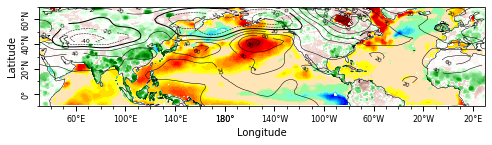

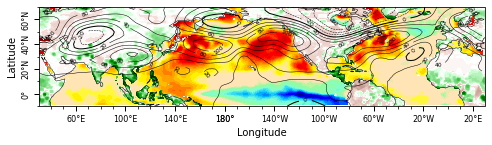

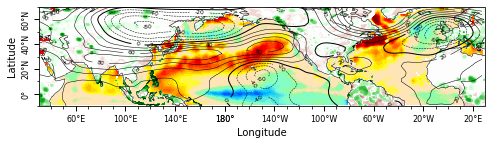

In [7]:
# T 3 boxAverage, starting with 3rd month (March 1979)
ds_rain = ds_rain_anom.rain[2:].coarsen(time=3,boundary='trim').mean()
ds_temp = ds_temp_anom.temp[2:].coarsen(time=3,boundary='trim').mean()
ds_z200 = ds_z200_anom.phi[2:].coarsen(time=3,boundary='trim').mean()

for month in ['2020-07','2020-10','2021-01']:
    fig = plt.figure(figsize=(8,4))

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
    ax.set_extent([30, 390, -10,  70], crs=ccrs.PlateCarree())

    temp = ds_temp.sel(time=f'{month}').squeeze().drop(['time'])
    rain = ds_rain.sel(time=f'{month}').squeeze().drop(['time'])
    z200 = ds_z200.sel(time=f'{month}').squeeze().drop(['time'])
    
    cb1 = temp.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, levels=41, cmap='correlationcolorscale', add_colorbar=False)
    cb2 = rain.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-10,vmax=10, levels=101, cmap='prcp_anomaly', add_colorbar=False)
    # put zorder=10 to put the contours on TOP
    CS  = z200.plot.contour (ax=ax, colors= 'k', linewidths=0.5, transform=ccrs.PlateCarree(),zorder=10, vmin=-100,vmax=100,levels=11)
    ax.clabel(CS, inline=1, fontsize=6, fmt='%1.0f')
    CS.collections[5].set_linewidth(1) # plot the zero line thicker

    # Add coasts
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    # Label x-axis and make tick labels
    ax.xaxis.set_label_text('Longitude',fontsize=10)
    ax.set_xticks(np.arange(-180,181,40), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter())
    ax.xaxis.set_minor_locator(MultipleLocator(10))

    # Label y-axis and make tick labels
    ax.yaxis.set_label_text('Latitude',fontsize=10)
    plt.yticks(np.arange(0,70,20), rotation=90, va='center')
    ax.yaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter())
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    # Make tick marks
    ax.tick_params(which='major', width=1.00, length=5, labelsize=8)
    ax.tick_params(which='minor', width=0.75, length=2.5)

    # do some cropping of the eps file so that we can use it in latex
    plt.savefig('plot.eps')
    os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/overlay_{month}.eps');

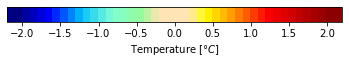

In [8]:
# plot just colorbar:
cb = ds_temp[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, levels=41, cmap='correlationcolorscale', add_colorbar=False)
plt.gca().set_visible(False)
cbar = plt.colorbar(cb, extendrect = True, label=r'Temperature [$\degree C$]', orientation='horizontal')
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/temp-colorbar.eps');

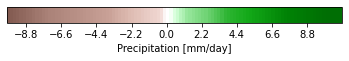

In [9]:
cb = ds_rain[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-10,vmax=10, levels=101, cmap='prcp_anomaly', add_colorbar=False)
plt.gca().set_visible(False)
cbar = plt.colorbar(cb, extendrect = True, label=r'Precipitation [mm/day]', orientation='horizontal')
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/rain-colorbar.eps');